### 1. Introduction

### 2. Data preparation
2.1 Load data
2.2 Check for null and missing values
2.3 Normalization
2.4 Reshape
2.5 Label encoding
2.6 Split training and valdiation set

### 3. CNN
3.1 Define the model
3.2 Set the optimizer and annealer
3.3 Data augmentation

### 4. Evaluate the model
4.1 Training and validation curves
4.2 Confusion matrix

### 5. Prediction and submition
5.1 Predict and Submit results

# 1. Introduction

This is a multi-layer Sequential Convolutional Neural Network for image recognition trained on CIFAR10 dataset. I have chosen to build it with keras API (Tensorflow backend) which is very intuitive. 

Firstly, I will prepare the data (60,000 32x32x3 RGB color images in 10 classes). Then, I will focus on the CNN modeling and evaluation.

I achieved ???? of accuracy with this CNN trained in ???? on Makerspace PC, which is supported with NVIDIA GPU grpahics card.  Due to graphics card, the computation will be much much faster has become much faster.


In [12]:
import os
os.environ['PYTHONHASHSEED']=str(0)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.compat.v1.set_random_seed(0)
import matplotlib.pyplot as plt
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
from keras.optimizers import adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.applications import ResNet50
from keras.utils import to_categorical
import csv
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
cifar_image_path = 'cifar-10-batches-py'

In [13]:
import optuna
from optuna.integration import KerasPruningCallback
tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.experimental.list_logical_devices('GPU')))

Num GPUs Available:  1


In [14]:
#function to load cifar-10 image-file (batch wise)
def load_cifar10_data(cifar_image_path, n_batch):
    
    features = []
    labels = []
    
    for batch_id in range(1, n_batch + 1):
        #'with open()'- opens the file 
        #f = open("path_to_file", mode='r+b') in reading + binary mode
        with open(cifar_image_path + '/data_batch_' + str(batch_id), mode='r+b') as file:
        
        
            #Module translates an in-memory Python object  
            #into a serialized byte stream—a string of  
            #bytes that can be written to any file-like object.
            #pickle.load - with filename
            #pickle.loads - without filename
            batch = pickle.load(file, encoding='latin1')
     
    
        for i in range(0, len(batch['labels'])):
        
            features.append(batch['data'][i])
            labels.append(batch['labels'][i])
    
    
    #divide the row vector (3072) into 3 pieces. Each piece corresponds to the each channels.
    #this results in (3 x 1024) dimension of tensor.
    #divide the resulting tensor from the previous step with 32. 32 here means width of an image.
    #this results in (3 x 32 x 32)    
    features = np.array(features)
    labels = np.array(labels)
    features = features.reshape((len(features), 3, 32, 32)).transpose(0, 2, 3, 1)
    
    
    #output is two arrays, first: feature matrix & second: label matrix
    return features, labels


#function to load cifar-10 test image-file
def load_cifar10_test_data(cifar_image_path):
    
    features = []
    labels = []
    
    with open(cifar_image_path + '/test_batch', mode='r+b') as file:
        
        batch = pickle.load(file, encoding='latin1')
     
    for i in range(0, len(batch['labels'])):
        
        features.append(batch['data'][i])
        labels.append(batch['labels'][i])
       
    features = np.array(features)
    labels = np.array(labels)
    features = features.reshape((len(features), 3, 32, 32)).transpose(0, 2, 3, 1)
    
    return features, labels

In [15]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i, l in enumerate(label_names):
    print("{}: {}".format(i,l))

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


Shape of feature-matrix containing image-data is given below (no. of images x image-dims) :
(50000, 32, 32, 3)
(50000,)
7


AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

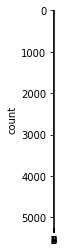

In [28]:
#loading images stored in 5 batches
features, labels = load_cifar10_data(cifar_image_path, 5)

print('Shape of feature-matrix containing image-data is given below (no. of images x image-dims) :')
print(features.shape)
print(labels.shape)
plt.imshow(features[545])
print(labels[545])

g = sns.countplot(labels)
labels.value_counts()

In [26]:
X_train, X_val, Y_train, Y_val = train_test_split(features, labels, test_size=0.2, random_state=14)
print("Training set shape: {}".format(X_train.shape))
#print("Test set shape: {}".format(X_test.shape))
print("Validation set shape: {}".format(X_val.shape))

Training set shape: (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)


In [5]:
#function to define desired lables to assign images in the dataset
def load_label_names():
    
    #returns array of strings for each class-name
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']    

In [6]:
def create_model(trial):
    # dropout in each layer

    model = Sequential()   
    model.add(
        Conv2D(
            filters=trial.suggest_categorical("filters", [32, 64]),
            kernel_size= (3,3),
            padding = 'same',
            activation= 'relu',
            input_shape=(32,32,3),
            )
        )  
    n_cnn = trial.suggest_int("n_cnn", 1, 3)
    if n_cnn > 0:
        num_filters1 = trial.suggest_categorical("n_filters_1", [32, 64])
        model.add(
            Conv2D(
            filters=num_filters1,
            kernel_size= (3,3),
            padding = 'same',
            activation= 'relu'
            )
        )
        if n_cnn > 1:
            num_filters2 = trial.suggest_categorical("n_filters_2", [64, 128])
            model.add(
                Conv2D(
                filters=num_filters2,
                kernel_size= (3,3),
                padding = 'same',
                activation= 'relu'
                )
            )
            if n_cnn > 2:
                num_filters3 = trial.suggest_categorical("n_filters_3", [64, 128])
                model.add(
                    Conv2D(
                    filters=num_filters3,
                    kernel_size= (3,3),
                    padding = 'same',
                    activation= 'relu'
                    )
                )    
                    
    model.add(MaxPooling2D(pool_size=(2,2)))   
    model.add(Flatten())
    
    n_layers = trial.suggest_int("n_layers", 1, 3)
    
    if n_layers > 0:
        num_hidden1 = trial.suggest_categorical("n_units_1", [128, 256, 512, 1024, 2048])
        model.add(Dense(num_hidden1, activation="relu"))
        dropout1 = trial.suggest_uniform("dropout_1", 0.1, 0.3)
        model.add(Dropout(rate=dropout1))
        if n_layers > 1:
            num_hidden2 = trial.suggest_categorical("n_units_2", [128, 256, 512, 1024, 2048])
            model.add(Dense(num_hidden2, activation="relu"))
            dropout2 = trial.suggest_uniform("dropout_2", 0.1, 0.3)
            model.add(Dropout(rate=dropout2))
            if n_layers > 2:
                num_hidden3 = trial.suggest_categorical("n_units_3", [128, 256, 512, 1024, 2048])
                model.add(Dense(num_hidden3, activation="relu"))
                dropout3 = trial.suggest_uniform("dropout_3", 0.1, 0.3)
                model.add(Dropout(rate=dropout3))
    
    model.add(Dense(10, activation="softmax"))

    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)    
    
    opt = SGD(lr = lr)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [7]:
def objective(trial):
    
    # clear clutter from previous session graphs.
    tf.keras.backend.clear_session()
    
    training_images, training_labels = load_cifar10_data(cifar_image_path, 5)
    training_images = training_images/255.0
    
    test_images, test_labels = load_cifar10_test_data(cifar_image_path)
    test_images = test_images/255.0

    print('Not using data augmentation.')
    
    # Generate our trial model.
    model = create_model(trial)
    
    # Fit the model on the training data.
    # The KerasPruningCallback checks for pruning condition every epoch.
    history = model.fit(training_images, training_labels, 
              callbacks=[KerasPruningCallback(trial, "val_acc")],
              epochs=15,
              validation_split = 0.1, verbose = 2)
    

    # Evaluate the model accuracy on the test set.
    score = model.evaluate(test_images, test_labels, verbose=0)
    print ('Test loss: {}, Test accuracy: {}'.format(score[0], score[1]*100.0))
    return score[1]


In [8]:
#sampler = optuna.integration.CmaEsSampler()
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(sampler = sampler, direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=35)
sampler = optuna.integration.CmaEsSampler(seed = 0)
study.optimize(objective, n_trials=15)
pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)          

[I 2020-05-06 09:18:18,114] Finished trial#0 resulted in value: 0.163100004196167. Current best value is 0.163100004196167 with parameters: {'filters': 32, 'n_cnn': 1, 'n_filters_1': 64, 'n_layers': 1, 'n_units_1': 512, 'dropout_1': 0.2015600143265444, 'lr': 1.8128567531123754e-05}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)          

[I 2020-05-06 09:20:47,278] Finished trial#1 resulted in value: 0.607200026512146. Current best value is 0.607200026512146 with parameters: {'filters': 64, 'n_cnn': 1, 'n_filters_1': 64, 'n_layers': 1, 'n_units_1': 256, 'dropout_1': 0.24231769575825113, 'lr': 0.0028302762662418693}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              16779264  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)          

[I 2020-05-06 09:24:12,897] Finished trial#2 resulted in value: 0.5192999839782715. Current best value is 0.607200026512146 with parameters: {'filters': 64, 'n_cnn': 1, 'n_filters_1': 64, 'n_layers': 1, 'n_units_1': 256, 'dropout_1': 0.24231769575825113, 'lr': 0.0028302762662418693}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              67110912  
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-06 09:30:41,296] Finished trial#3 resulted in value: 0.18880000710487366. Current best value is 0.607200026512146 with parameters: {'filters': 64, 'n_cnn': 1, 'n_filters_1': 64, 'n_layers': 1, 'n_units_1': 256, 'dropout_1': 0.24231769575825113, 'lr': 0.0028302762662418693}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-06 09:33:17,705] Finished trial#4 resulted in value: 0.1446000039577484. Current best value is 0.607200026512146 with parameters: {'filters': 64, 'n_cnn': 1, 'n_filters_1': 64, 'n_layers': 1, 'n_units_1': 256, 'dropout_1': 0.24231769575825113, 'lr': 0.0028302762662418693}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-06 09:36:24,884] Finished trial#5 resulted in value: 0.4499000012874603. Current best value is 0.607200026512146 with parameters: {'filters': 64, 'n_cnn': 1, 'n_filters_1': 64, 'n_layers': 1, 'n_units_1': 256, 'dropout_1': 0.24231769575825113, 'lr': 0.0028302762662418693}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)          

[I 2020-05-06 09:38:44,639] Finished trial#6 resulted in value: 0.6164000034332275. Current best value is 0.6164000034332275 with parameters: {'filters': 32, 'n_cnn': 1, 'n_filters_1': 64, 'n_layers': 1, 'n_units_1': 256, 'dropout_1': 0.24359973500827223, 'lr': 0.0029289530023016595}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              67110912  
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-06 09:44:46,944] Finished trial#7 resulted in value: 0.45570001006126404. Current best value is 0.6164000034332275 with parameters: {'filters': 32, 'n_cnn': 1, 'n_filters_1': 64, 'n_layers': 1, 'n_units_1': 256, 'dropout_1': 0.24359973500827223, 'lr': 0.0029289530023016595}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)          

[I 2020-05-06 09:47:06,023] Finished trial#8 resulted in value: 0.6438000202178955. Current best value is 0.6438000202178955 with parameters: {'filters': 32, 'n_cnn': 1, 'n_filters_1': 64, 'n_layers': 3, 'n_units_1': 512, 'dropout_1': 0.21527814576195614, 'n_units_2': 2048, 'dropout_2': 0.27989794854532457, 'n_units_3': 512, 'dropout_3': 0.11789802009218792, 'lr': 0.005293631794429913}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-06 09:49:25,933] Finished trial#9 resulted in value: 0.2433999925851822. Current best value is 0.6438000202178955 with parameters: {'filters': 32, 'n_cnn': 1, 'n_filters_1': 64, 'n_layers': 3, 'n_units_1': 512, 'dropout_1': 0.21527814576195614, 'n_units_2': 2048, 'dropout_2': 0.27989794854532457, 'n_units_3': 512, 'dropout_3': 0.11789802009218792, 'lr': 0.005293631794429913}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 09:52:51,749] Finished trial#10 resulted in value: 0.6808000206947327. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 09:57:34,191] Finished trial#11 resulted in value: 0.6628999710083008. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 10:01:22,050] Finished trial#12 resulted in value: 0.6189000010490417. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 10:04:46,535] Finished trial#13 resulted in value: 0.6722999811172485. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 10:09:49,897] Finished trial#14 resulted in value: 0.3788999915122986. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 10:13:09,238] Finished trial#15 resulted in value: 0.4456999897956848. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 10:16:43,826] Finished trial#16 resulted in value: 0.20160000026226044. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 10:20:03,091] Finished trial#17 resulted in value: 0.669700026512146. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 10:24:36,562] Finished trial#18 resulted in value: 0.4961000084877014. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 10:29:12,634] Finished trial#19 resulted in value: 0.5895000100135803. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 10:32:03,288] Finished trial#20 resulted in value: 0.6553000211715698. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 10:35:24,538] Finished trial#21 resulted in value: 0.6201000213623047. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 10:38:47,075] Finished trial#22 resulted in value: 0.6748999953269958. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 10:42:07,435] Finished trial#23 resulted in value: 0.5170999765396118. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 10:45:33,413] Finished trial#24 resulted in value: 0.661300003528595. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2097280   
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-06 10:47:45,984] Finished trial#25 resulted in value: 0.4449000060558319. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 10:51:16,760] Finished trial#26 resulted in value: 0.6556000113487244. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 10:54:35,700] Finished trial#27 resulted in value: 0.5820000171661377. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              16778240  
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-06 10:57:42,150] Finished trial#28 resulted in value: 0.6302000284194946. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 11:00:31,175] Finished trial#29 resulted in value: 0.3257000148296356. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 11:03:45,391] Finished trial#30 resulted in value: 0.490200012922287. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 11:07:14,062] Finished trial#31 resulted in value: 0.6470999717712402. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 11:10:38,587] Finished trial#32 resulted in value: 0.6248000264167786. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 11:14:03,986] Finished trial#33 resulted in value: 0.5612999796867371. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 11:16:54,089] Finished trial#34 resulted in value: 0.5960999727249146. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 11:21:03,535] Finished trial#35 resulted in value: 0.5659999847412109. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              16778240  
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-06 11:23:58,402] Finished trial#36 resulted in value: 0.5996000170707703. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 11:26:51,161] Finished trial#37 resulted in value: 0.49230000376701355. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              33556480  
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-06 11:31:00,664] Finished trial#38 resulted in value: 0.6590999960899353. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 11:33:22,957] Finished trial#39 resulted in value: 0.14630000293254852. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dropout_1 (Dropout)      

[I 2020-05-06 11:37:40,412] Finished trial#40 resulted in value: 0.5806999802589417. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 11:41:10,356] Finished trial#41 resulted in value: 0.6209999918937683. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 11:45:56,869] Finished trial#42 resulted in value: 0.6478000283241272. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 11:49:50,662] Finished trial#43 resulted in value: 0.6675000190734863. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 11:54:39,579] Finished trial#44 resulted in value: 0.6499999761581421. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 11:58:33,201] Finished trial#45 resulted in value: 0.6621000170707703. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 12:02:02,515] Finished trial#46 resulted in value: 0.553600013256073. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)          

[I 2020-05-06 12:04:04,969] Finished trial#47 resulted in value: 0.641700029373169. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 12:08:08,552] Finished trial#48 resulted in value: 0.6794000267982483. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Not using data augmentation.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       36992     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)          

[I 2020-05-06 12:11:53,247] Finished trial#49 resulted in value: 0.10329999774694443. Current best value is 0.6808000206947327 with parameters: {'filters': 32, 'n_cnn': 3, 'n_filters_1': 64, 'n_filters_2': 64, 'n_filters_3': 64, 'n_layers': 3, 'n_units_1': 1024, 'dropout_1': 0.14368693387820625, 'n_units_2': 1024, 'dropout_2': 0.23647794186266582, 'n_units_3': 128, 'dropout_3': 0.22482003308554918, 'lr': 0.007760788325617688}.


Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  0
  Number of complete trials:  50
Best trial:
  Value:  0.6808000206947327
  Params: 
    filters: 32
    n_cnn: 3
    n_filters_1: 64
    n_filters_2: 64
    n_filters_3: 64
    n_layers: 3
    n_units_1: 1024
    dropout_1: 0.14368693387820625
    n_units_2: 1024
    dropout_2: 0.23647794186266582
    n_units_3: 128
    dropout_3: 0.22482003308554918
    lr: 0.007760788325617688


In [9]:
with open("Optuna_result_CIFAR10_dict_Mix.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Results"])
    for trial in study.trials:
        writer.writerow([trial.value])

In [10]:
for i in range(50):
    print(study.trials[i].value)

0.163100004196167
0.607200026512146
0.5192999839782715
0.18880000710487366
0.1446000039577484
0.4499000012874603
0.6164000034332275
0.45570001006126404
0.6438000202178955
0.2433999925851822
0.6808000206947327
0.6628999710083008
0.6189000010490417
0.6722999811172485
0.3788999915122986
0.4456999897956848
0.20160000026226044
0.669700026512146
0.4961000084877014
0.5895000100135803
0.6553000211715698
0.6201000213623047
0.6748999953269958
0.5170999765396118
0.661300003528595
0.4449000060558319
0.6556000113487244
0.5820000171661377
0.6302000284194946
0.3257000148296356
0.490200012922287
0.6470999717712402
0.6248000264167786
0.5612999796867371
0.5960999727249146
0.5659999847412109
0.5996000170707703
0.49230000376701355
0.6590999960899353
0.14630000293254852
0.5806999802589417
0.6209999918937683
0.6478000283241272
0.6675000190734863
0.6499999761581421
0.6621000170707703
0.553600013256073
0.641700029373169
0.6794000267982483
0.10329999774694443


In [11]:
print("  Value: ", study.best_trial.value)

print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

  Value:  0.6808000206947327
  Params: 
    filters: 32
    n_cnn: 3
    n_filters_1: 64
    n_filters_2: 64
    n_filters_3: 64
    n_layers: 3
    n_units_1: 1024
    dropout_1: 0.14368693387820625
    n_units_2: 1024
    dropout_2: 0.23647794186266582
    n_units_3: 128
    dropout_3: 0.22482003308554918
    lr: 0.007760788325617688
